# Causal Inference

In [1]:
import numpy as np
import pandas as pd

from fklearn.training.regression import xgb_regression_learner
from fklearn.training.classification import xgb_classification_learner, logistic_classification_learner
from fklearn.training.causal_inference import IPTW_learner
from fklearn.validation.evaluators import r2_evaluator, roc_auc_evaluator
from fklearn.data.datasets import make_confounded_data

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

N=50000
features = ["sex", "age", "severity"]
treatment = ["medication"]

/opt/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Synthetic Data Model

To better understand counterfactual inference, we will use a synthetic data, for which the generating process is known. More precisely, the data which is generated from the following model


$Sex \sim  \mathcal{B}(0.5)$  
  
$Age \sim \operatorname{Gamma}(8, 4)$
  
$Severity \sim \mathbb{1}_{\{age < 30\}} \operatorname{Beta}(1,3) + \mathbb{1}_{\{age \geq 30\}} \operatorname{Beta}(3,1.5)$  
  
$Treat \sim \mathcal{B}(-0.8 + 0.33*sex + 1.5*severity)$  
  
$Recovery = \operatorname{Poisson}(2+0.5 * sex+0.03 * age+ 1*severity-1 * medication)$  
  
We can see that the linear factor that multiply the medication is $-1$. Since this relation is inside a Poisson model, we can say that the expected causal effect of medication on recovery time is $exp(-1)\approx 0.36$. We can also see that there are lots of confounding in the above model. For instance, Severity directly influences both the probability of treatment and the recovery time directly. The same if true for sex, with the additional complication that sext also influences on the severity of the daisies. Finally, age directly influences the recovery time and affect treatment only indirectly through influence in severity. Moreover, there are some non trivial data, like the severity, which is a mixture of two Beta distribution.

The function bellow generates such data. It returns a Data Frame for which the treatment is randomly assigned, one DataFrame that simulates a observational dataset with the a above treatment probability. It also returns a third DataFrame, just like the simulated observational one, but with the treatment inverted. This will be the counterfactual dataframe.

In [2]:
df_rnd, df_obs, df_cf = make_confounded_data(N)

/opt/anaconda/lib/python2.7/site-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Lets now see the correlations present in this dataframe. As you can see, all variables are correlated with both recovery and treatment assignment, which is the typical confounding scenario.

In [3]:
df_obs.corr()

,sex,age,severity,medication,recovery
sex,1.000000,-0.005599,-0.003693,0.208767,0.264228
age,-0.005599,1.000000,0.566635,0.463141,0.601405
severity,-0.003693,0.566635,1.000000,0.792594,0.177204
medication,0.208767,0.463141,0.792594,1.000000,-0.097037
recovery,0.264228,0.601405,0.177204,-0.097037,1.000000


## Naive Model

Lets first try to fit a model directly to the responde variable (recovery) without much attention to confounding. 

In [4]:
regr_learner = xgb_regression_learner(features=features + treatment, target="recovery")

First, we fit it to the the data where the treatment is randomly assigned.

In [5]:
sem_fn, df_rnd, _ = regr_learner(df_rnd)

To get the average causal effect, we create two dataframes, one for which everyone receives the treatment and one for which no one receives it. We then run the model for both datasets and divide their predictions

In [6]:
X_neg = df_rnd.copy()
X_pos = df_rnd.copy()

X_neg["medication"] = 0
X_pos["medication"] = 1

preds_rnd = sem_fn(X_pos)["prediction"] / sem_fn(X_neg)["prediction"]
preds_rnd.mean()

0.369575560092926

As we can see it is trivial to identify the causal effect if the treatment is randomly assigned. Bellow, we plot the predicted treatment effect distribution with the true average treatment effect and the predicted one

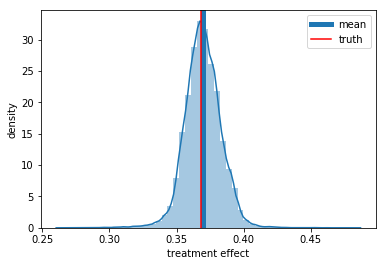

In [7]:
ax = sns.distplot(preds_rnd)
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.axvline(np.mean(preds_rnd), label='mean', lw=5)
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

Now for the hard part. Lets try to use the same naive model for the data where there is confounding.  

In [8]:
sem_fn, df_obs, _ = regr_learner(df_obs)

In [9]:
X_neg = df_obs.copy()
X_pos = df_obs.copy()

X_neg["medication"] = 0
X_pos["medication"] = 1

preds_rnd = sem_fn(X_pos)["prediction"] / sem_fn(X_neg)["prediction"]
preds_rnd.mean()

0.42235738039016724

We can see now that the treatment effect is now underestimated ($log(0.41) = -0.89$), so we predict that the treatment has less impact than it actually does. But why is that? Well just to give one reason, if we recall the data generating process, we will notice that severity is causes a longer recovery period and a greater probability of treatment. Thus, some of the negative effect of severity goes to the correlation of treatment with recovery time, which appears to be smaller than the actual causal effect.

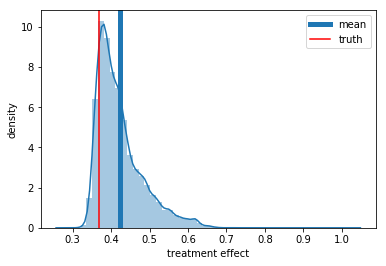

In [10]:
ax = sns.distplot(preds_rnd)
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.axvline(np.mean(preds_rnd), label='mean', lw=5)
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();

Finally, lets see how does out model performs in both the factual and counter factual data.

In [11]:
eval_fn = r2_evaluator(prediction_column="prediction",target_column="recovery")

print "Factual Evaluation:", eval_fn(sem_fn(df_obs))
print "Counter Factual Evaluation", eval_fn(sem_fn(df_cf))

Factual Evaluation: {'r2_evaluator__recovery': 0.8669406871788605}
Counter Factual Evaluation {'r2_evaluator__recovery': 0.8341172823328981}


## IPTW  Model

Having played a little with the a naive benchmark, lets now use a framework that is meant to uncover causal relation, the Inverse Probability of Treatment Waiting framework. The idea is very simple. We first fit a model to predict the probability of treatment. Then, we overweight two kinds of samples: the treated with low form whom the predicted probability of treatment is low and the untreated for whom the predicted probability is high. The intuition is that this will make the model focus on the treated that looks like the untreated and on the untreated that looks like the treated.

In order for this to work we have to watch out for two things:

    1) Treatment assignment should not be deterministic on the covariates. In other words, everyone should have a probability of being treated. This is some times referred as the positivity assumption of causal inference.
    2) All variables that influence the responde (recovery time) and treatment assignment should be observable. Another way to say this is that treatment is randomly assigned given once we account for the covariates. This is sometimes referred as the unconfoundedness assumption.
    
Trouble is, although we can check for assumption 1) wit the data, there is no way to check for assumption 2). Here, we know how the data was generated and we know that we have unconfoundedness, but, in general, we have to rely on experts intuition about the problem we try to model.

OK. Back to the model. Lets split our data fist.

In [12]:
train, test, _, _ = train_test_split(df_obs, df_obs, test_size=0.33, random_state=42)

Now, we will fit the IPTW learner. It takes tow extra learners as inputs: a classification model to predict the probability of treatment and a response model that, on this case, will be a regression one, since the our response variable is continuous.

In [13]:
causal_learner = IPTW_learner(features=features, target="recovery", treatment = "medication",
                              ps_learner = xgb_classification_learner(num_estimators=25, extra_params={"max_depth": 2}),
                              response_learner = xgb_regression_learner)

The IPTW predict function returns a DataFrame with the predicted response variable, the propensity scores and the weight of the each samples.

In [14]:
sem_fn, train_pred, _ = causal_learner(train)
test_pred = sem_fn(test)
train_pred.head()

,sex,age,severity,medication,recovery,prediction,propensity_score,weight,counterfactual
23990,0,22.357267,0.797063,1.0,9,12.010621,0.903162,1.107221,12.305794
8729,0,10.764319,0.165695,0.0,12,11.791059,0.046857,1.049161,12.667633
3451,1,24.046842,0.494215,1.0,13,15.043891,0.791081,1.264093,15.231667
2628,1,30.389036,0.567990,1.0,24,20.715506,0.889086,1.124750,20.982327
38352,1,23.535528,0.050463,0.0,28,26.280563,0.137160,1.158963,25.861427


Before we process, it a good idea to validate our propensity score classifier. It better not overffit! If iid does, it will be very confident, giving extremely low probability of treatment to the untreated and extremely hight probability of treatment for the treated. This will result in no overlap in in the propensity score for the treated and untreated, which will be a near violation of the positivity assumption. Also, if our model can precisely predict the treatment assignment, it means it is a deterministic function of the covariates, also violating the positivity assumption.

In [15]:
ps_eval_fn = roc_auc_evaluator(prediction_column="propensity_score", target_column="medication")
ps_eval_fn(train_pred), ps_eval_fn(test_pred) 

({'roc_auc_evaluator__medication': 0.9780837845595602},
 {'roc_auc_evaluator__medication': 0.976750491771322})

No handlers could be found for logger "matplotlib.legend"


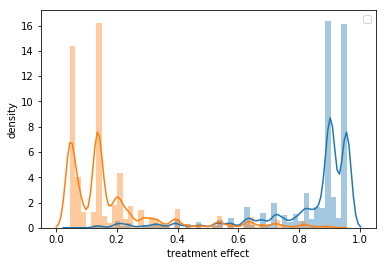

In [16]:
# check for positivity
ax = sns.distplot(train_pred[train_pred["medication"] == 1]["propensity_score"])
sns.distplot(train_pred[train_pred["medication"] == 0]["propensity_score"])
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.legend();

OK. We can see that our propensity score model is not overfilling, but it is also very good. When we plot the propensity score distribution for treated and untreated we can see that there is almost no overlap between them. This might give us some trouble, since is a near violation of the positivity assumption. 

Now, lets validate our responde prediction on both factual and counterfactual data. We can see that it is already better than the naive model.

In [17]:
sem_eval_fn = r2_evaluator(prediction_column="counterfactual", target_column="recovery")
sem_eval_fn(train_pred), sem_eval_fn(test_pred) 

({'r2_evaluator__recovery': 0.8686622319366993},
 {'r2_evaluator__recovery': 0.8539786349462983})

Finally, lets see the predicted average treatment effect. We can see that it is not perfect, but is much better already.

In [18]:
X_neg = train_pred.copy()
X_pos = train_pred.copy()

X_neg["medication"] = 0
X_pos["medication"] = 1

preds_rnd = sem_fn(X_pos)["counterfactual"] / sem_fn(X_neg)["counterfactual"]
preds_rnd.mean()

0.38716813921928406

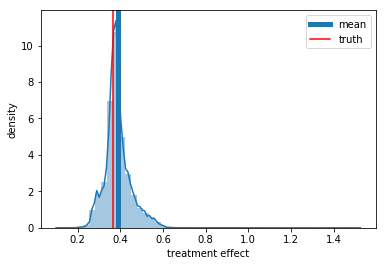

In [19]:
ax = sns.distplot(preds_rnd)
ax.set_xlabel('treatment effect')
ax.set_ylabel('density')
plt.axvline(np.mean(preds_rnd), label='mean', lw=5)
plt.axvline(np.exp(-1), color='r', label='truth')
plt.legend();